### Imputation Method 

Compare different imputation methods for different windows of imputation. 

In [40]:
# Setup
import numpy as np
import pickle
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from prophet import Prophet
import plotly.express as px

# Multiple outputs per cell
%config InteractiveShell.ast_node_interactivity = 'all'

# Functions
def create_hour_minute(df):
    '''
    This function is supplemental to the following 'add_time_features' function,
    creating an hour_minute variable
    '''
    # Initialize empty variable
    df['hour_minute'] = None

    # Conditions
    conditions = [df['utc_timestamp'].dt.minute == 15,
                  df['utc_timestamp'].dt.minute == 30,
                  df['utc_timestamp'].dt.minute == 45]
    
    transform = [df['utc_timestamp'].dt.hour + .25,
                 df['utc_timestamp'].dt.hour + .5,
                 df['utc_timestamp'].dt.hour + .75]
    
    # given conditions, transform 
    converted_times = np.select(conditions, transform, df['utc_timestamp'].dt.hour)

    return converted_times

def create_impute_groups(data, y):
    '''
    Given dataframe with variable to impute, returns 
    a group number for that NA, how many consecutive
    NAs there are, and the first + last index values of 
    the consecutive NAs
    '''
    # note NA values in dataframe
    df = (data.set_index('utc_timestamp') # data or self.data
            .isna()
            .reset_index(drop=True)
          )
    
    # Assign groups of NAs a unique group number
    group_num = 0
    groups = [0]
    for i in range(len(df[y].values)-1): # y or self.y
        value = df[y].values[i]
        next_value = df[y].values[i+1]

        if value == False and next_value == True:
            group_num += 1
        if next_value == None:
            continue
        if value == False:
            groups.append(0)
        else: 
            groups.append(group_num)

    # Add na groups and index columns to df
    df['missing_group_num'] = groups 
    df['index'] = list(range(0, len(df)))

    missing_lengths = (df.groupby('missing_group_num', as_index=False)
                       .agg(consecutive = ('missing_group_num', 'count'),
                            first_na_idx = ('index', 'min'),
                            # adding 2 to last index for imputation
                            last_na_idx = ('index', lambda x: x.max() + 2)) 
                       .iloc[1:] # remove non_na groups
                       .sort_values('first_na_idx')
                       )
    
    return missing_lengths

def agg_results(impute_results):
    cols = [*impute_results.columns[3:]] # ignoring cols to not agg over

    agg_result = (impute_results.groupby('n', as_index=False)
                        .agg({col: [(f'{col}_mean', 'mean'), (f'{col}_std', 'std')] for col in cols}))

    agg_result.columns = [f'{col[1]}' for col in agg_result.columns] # col[1]
    agg_result = agg_result.rename(columns={'': 'n'}).round(3)

    return agg_result

def plot_imputation_results(agg_result):
    mean_cols = [col for col in agg_result.columns if col.endswith('_mean')]

    fig = px.line(
        data_frame=agg_result,
        x='n',
        y=mean_cols,
        title='Imputation Comparison Results'
    )

    fig.show()

In [31]:
# Read in data for developing imputation method
cd = Path.cwd()
data_dir = str(cd.parents[1])
load_energy_dt = data_dir + '/datasets/country_energy/country_load.pickle'

# Read pickle data 
with open(load_energy_dt, 'rb') as f:
    country_actuals = (pickle.load(f)[['utc_timestamp', 'country', 'load_actual_entsoe_transparency']])

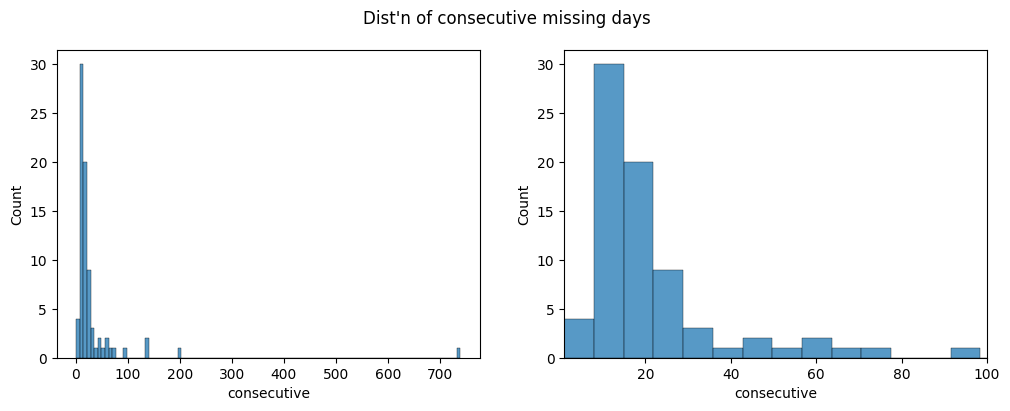

In [32]:
missing_lengths = create_impute_groups(country_actuals, 'load_actual_entsoe_transparency')

# Hist of missing lengths, omitting complete data
fig, ax = plt.subplots(1, 2, figsize=(12,4))
_ = sns.histplot(data=missing_lengths[1:], x='consecutive', stat='count', ax=ax[0])
_ = sns.histplot(data=missing_lengths[1:], x='consecutive', stat='count', ax=ax[1])
_ = ax[1].set_xlim(1,100)
_ = plt.suptitle("Dist'n of consecutive missing days")
plt.show()

In [33]:
country_actuals.head()

,utc_timestamp,country,load_actual_entsoe_transparency
0,2014-12-31 23:15:00+00:00,AT,6088.0
1,2014-12-31 23:30:00+00:00,AT,6060.0
2,2014-12-31 23:45:00+00:00,AT,5957.6
3,2015-01-01 00:00:00+00:00,AT,6017.2
4,2015-01-01 00:15:00+00:00,AT,5966.8


In [34]:
test = country_actuals.set_index('utc_timestamp').isna().reset_index(drop=True)
test
group_num = 0 
groups = [0] ### --- Problem is that 'to_impute' must be hardcoded
for i in range(len(test['load_actual_entsoe_transparency'].values)-1): # y or self.y
    value = test['load_actual_entsoe_transparency'].values[i]
    next_value = test['load_actual_entsoe_transparency'].values[i+1]

    if value == False and next_value == True:
        group_num += 1
    if next_value == None:
        continue
    if value == False:
        groups.append(0)
    else: 
        groups.append(group_num)
# groups
sum(groups)
create_impute_groups(country_actuals, 'load_actual_entsoe_transparency')

,country,load_actual_entsoe_transparency
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
910669,False,False
910670,False,False
910671,False,False
910672,False,False


148843

,missing_group_num,consecutive,first_na_idx,last_na_idx
1,1,1,151779,151781
2,2,9,289359,289369
3,3,1,303558,303560
4,4,20,448481,448502
5,5,47,449094,449142
...,...,...,...,...
76,76,16,905955,905972
77,77,12,905991,906004
78,78,24,906011,906036
79,79,9,906062,906072


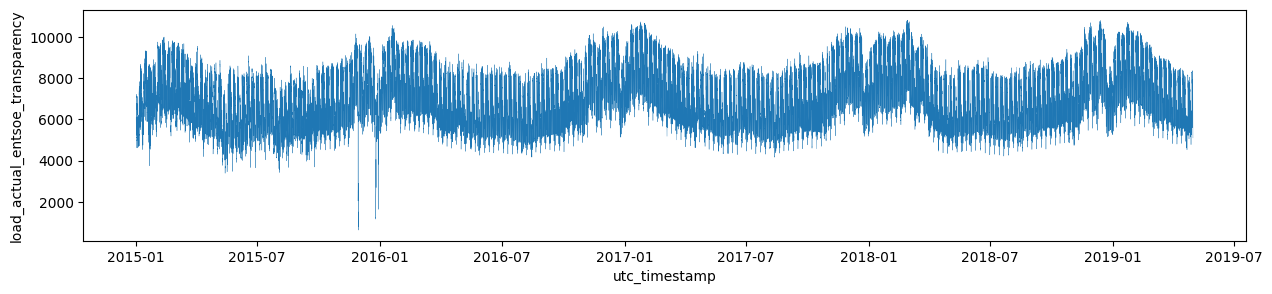

In [35]:
### Developing imputation algorithm with AT due 
# # to there being a full dataset
plot_dt = country_actuals.loc[lambda x: x.country == 'AT']

_ = plt.figure(figsize=(15, 3))

_ = sns.lineplot(
    data=plot_dt, 
    x='utc_timestamp', 
    y='load_actual_entsoe_transparency', 
    linewidth=0.25)

plt.show()

## Impute method comparison
- Select AT due to their being no NA values for imputation test
- Create window of size n: 2 through 96 (by 2)
    - Randomly sample 24 windows slightly larger than size n from dataset
    - Place n nans in dataset
    - Across the 24 windows, get average mae for a given imputation method
- Display table results of imputation methods across the windows
- Display plots of results comparing methods

### Testing Loop parallelized with Ray

In [36]:
import ray

Without Class Structure

In [57]:
### For test, Limiting to AT due to no missing data

@ray.remote
def create_hour_minute(df):
    '''
    This function is supplemental to the following 'add_time_features' function,
    creating an hour_minute variable
    '''
    # Initialize empty variable
    df['hour_minute'] = None

    # Conditions
    conditions = [df['utc_timestamp'].dt.minute == 15,
                  df['utc_timestamp'].dt.minute == 30,
                  df['utc_timestamp'].dt.minute == 45]
    
    transform = [df['utc_timestamp'].dt.hour + .25,
                 df['utc_timestamp'].dt.hour + .5,
                 df['utc_timestamp'].dt.hour + .75]
    
    # given conditions, transform 
    converted_times = np.select(conditions, transform, df['utc_timestamp'].dt.hour)

    return converted_times

@ray.remote
def create_impute_data(data):
    '''
    Creates main dataset for this experiment, which includes day,
    weekday, and hour_minute. The chosen country, 'AT' (Austria),
    has complete data, making experimentation easy. 
    '''
    impute_data = (data.assign(
            day = lambda x: x['utc_timestamp'].dt.day,
            weekday = lambda x: x['utc_timestamp'].dt.strftime('%a'),
            hour_minute = lambda x: ray.get(create_hour_minute.remote(x))
        )
        .loc[lambda x: x.country == 'AT']
        .reset_index(drop=True)
        ) 

    return impute_data

@ray.remote
def create_window_idx(data, num_windows=24):
    # indices to loop over for get mae across 24 samples
    impute_windows = list(data.sample(num_windows, random_state=24).index)
    return impute_windows

@ray.remote
def create_weekday_impute(data):
    '''
    Creates average over a weekday time period, 
    for imputing load_actal_entsoe_transparency values.
    '''
    # Weekday impute method
    weekday_impute = (data.groupby(['weekday', 'hour_minute'], as_index=False)
                    .agg(avg_weekday_actuals = ('load_actual_entsoe_transparency', lambda x: x.mean().round(2)))
                    )
    week_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    weekday_impute['weekday'] = pd.Categorical(
        weekday_impute['weekday'], 
        categories=week_order, 
        ordered=True
        )
    weekday_impute = weekday_impute.sort_values(by=['weekday','hour_minute'])
    
    return weekday_impute

In [58]:
# Goals: Resolve the following --- Solution may have been method of creating the fcst dataframe ---

@ray.remote
def create_impute_window(data, n, idx, forecast=False): 
    '''
    Creates imputation window with n NAs at index idx. 
    Window:
        1 row of available data, 
        n rows of NAs, 
        2 rows of available data
    
    If forecast=True, then there is up to 6months of data before NA values.
    
    This is done to ensure all imputation methods can impute without error
    '''

    window = data.iloc[idx-1:idx+n+2]
    window['to_impute'] = window['load_actual_entsoe_transparency'];  
    window.loc[idx:idx+n-1, 'to_impute'] = np.nan

    # forecast impute window, which has additional data for forcasting
    if forecast:
        ### Future: consider dynamic forecast window
        one_year_data = int((2880 * 12) / 2) # Selecting all data available, up to 6 months
        fcst_start = max(idx - one_year_data, 0) 
        fcst_window = data.iloc[fcst_start:idx+n+2]
        fcst_window['to_impute'] = fcst_window['load_actual_entsoe_transparency'];  
        fcst_window.loc[idx:idx+n-1, 'to_impute'] = np.nan

        return fcst_window
    
    return window

@ray.remote
def create_impute_groups(data, y):
    '''
    Given dataframe with variable to impute, returns 
    a group number for that NA, how many consecutive
    NAs there are, and the first + last index values of 
    the consecutive NAs
    '''
    # note NA values in dataframe
    df = (data.set_index('utc_timestamp') # data or self.data
            .isna()
            .reset_index(drop=True)
          )
    
    # Assign groups of NAs a unique group number
    group_num = 0
    groups = [0]
    for i in range(len(df[y].values)-1): # y or self.y
        value = df[y].values[i]
        next_value = df[y].values[i+1]

        if value == False and next_value == True:
            group_num += 1
        if next_value == None:
            continue
        if value == False:
            groups.append(0)
        else: 
            groups.append(group_num)

    # Add na groups and index columns to df
    df['missing_group_num'] = groups 
    df['index'] = list(range(0, len(df)))

    missing_lengths = (df.groupby('missing_group_num', as_index=False)
                       .agg(consecutive = ('missing_group_num', 'count'),
                            first_na_idx = ('index', 'min'),
                            # adding 2 to last index for imputation
                            last_na_idx = ('index', lambda x: x.max() + 2)) 
                       .iloc[1:] # remove non_na groups
                       .sort_values('first_na_idx')
                       )
    
    return missing_lengths

@ray.remote
def forecast_impute(data, y, model_type='AutoETS'): # AutoETS AAA
    '''
    Given forecasting data and y, creates a forecast model
    with a horizon depending on the number of NAs needing
    imputation.
    Currently, can select 'AutoETS' or 'Prophet' as forecasting models.
    '''
    # from statsforecast import StatsForecast
    # from statsforecast.models import AutoETS
    data = data.reset_index(drop=True)
    impute_info = ray.get(create_impute_groups.remote(data, y))
        
    first_na = impute_info['first_na_idx'].iloc[0] 

    # Defining start, end, and horizon points of training window
    one_year_data = 2880 * 6 # Selecting all data available, up to 6 months
    start = max(first_na - one_year_data, 0)  
    end = first_na - 1 
    
    horizon = impute_info['consecutive'].iloc[0]
    fcst_df = (data.iloc[start:end] 
            .assign(index = 1) 
            [['index', 'utc_timestamp', y]]) # --- This needs to be generalized

    if model_type == 'AutoETS':
        pd.options.mode.chained_assignment = None

        fcst_df = (data.iloc[start:end] 
            .assign(index = 1) 
            [['index', 'utc_timestamp', y]])

        impute_model = StatsForecast(
            models=[AutoETS(model='AAA', season_length=96)], # --- season_length=96 (1 day) or maybe 1 week
            freq='15min', # --- Needs generalizaiton
            n_jobs=-1,
            verbose=False
            ) 

        result = impute_model.forecast(
            df=fcst_df, 
            id_col='index',
            time_col='utc_timestamp', # --- Needs generalization 
            target_col=y, # --- Needs generalization
            h=horizon,
            # show progress = False,
            ).rename(columns={'AutoETS': 'imputed'})
        
        return result['imputed'] # --- Needs generalization
    
    if model_type == 'Prophet':
        fcst_df = (data.iloc[start:end] 
           .rename(columns={'utc_timestamp': 'ds',
                             f"{y}": 'y'})
            [['ds', 'y']])
            
        fcst_df['ds'] = fcst_df['ds'].dt.tz_localize(None)
        
        model = (Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            seasonality_mode='additive',
            )
            .add_seasonality(name='intraday', 
                             period=96/2,  # (4 * 24 / 2) 15 min intervals
                             fourier_order=4)
            .fit(fcst_df[1:])) # ds and y only
        # further improvement if holidays are added

        # create dataframe of length horizon with the ds component
        predict_window = (data.iloc[first_na-1:first_na+horizon-1]
                          .rename(columns={'utc_timestamp': 'ds'})
                          [['ds']])
        predict_window['ds'] = predict_window['ds'].dt.tz_localize(None)        
        
        result = (model.predict(predict_window)
                  .rename(columns={'yhat': 'to_impute'}))
        
        return result['to_impute'] # --- Needs generalization

@ray.remote
def imputation_test(data, n, idx, i):
    '''
    Imputes n values in the data with several imputation methods and 
    stores the results.

    This function pairs with th eimputation comparison function,
    resulting in an automated loop for comparing imputation values
    '''
    
    # create impute windows
    window = ray.get(create_impute_window.remote(data, n, idx))
    fcst_window = ray.get(create_impute_window.remote(data, n, idx, forecast=True))
    weekday_impute = ray.get(create_weekday_impute.remote(data))

    # Weekday average impute method
    window = window.merge(weekday_impute, how='left', on=['weekday', 'hour_minute'])

    # Interpolation impute methods
    window['lin_nearest_impute'] = window['to_impute'].interpolate(method="nearest")
    window['lin_linear_impute'] = window['to_impute'].interpolate(method="linear")
    window['spline_impute'] = window['to_impute'].interpolate(method="spline", order=2)

    # # fcst_impute with load_actual, horizon chosen within, then add rows to the window to calculate the MAE
    fcst_impute = ray.get(forecast_impute.remote(fcst_window, 'to_impute', model_type='AutoETS'))  # Prophet
    prophet_fcst_impute = ray.get(forecast_impute.remote(fcst_window, 'to_impute', model_type='Prophet'))
    del fcst_window
    first_value = window['to_impute'][0]
    last_values = window['to_impute'][-2:].values

    fcst_imputed = [first_value, *fcst_impute.values, *last_values]
    prophet_fcst_imputed = [first_value, *prophet_fcst_impute.values, *last_values]

    window['fcst_imputed'] = fcst_imputed
    window['fcst_impute_smooth'] = pd.Series(fcst_imputed).ewm(alpha=.5).mean()
    window['prophet_fcst_imputed'] = prophet_fcst_imputed
    window['prophet_fcst_imputed_smooth'] = pd.Series(prophet_fcst_imputed).ewm(alpha=.5).mean()

    lin_nearest_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['lin_nearest_impute']
        )
    lin_linear_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['lin_linear_impute']
        )
    spline_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['spline_impute']
        )
    weekday_actuals_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['avg_weekday_actuals']
        )
    fcst_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['fcst_imputed']
        )
    prophet_fcst_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['prophet_fcst_imputed']
        )
    fcst_smooth_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['fcst_impute_smooth']
        )
    prophet_fcst_smooth_mae = mean_absolute_error(
        window['load_actual_entsoe_transparency'], 
        window['prophet_fcst_imputed_smooth']
        )

    result = pd.DataFrame({ 
        "trial": [i+1],
        "n": [n],
        "lin_nearest_mae": [lin_nearest_mae],
        "lin_linear_mae": [lin_linear_mae],
        "spline_mae": [spline_mae],
        "weekday_actuals_mae": [weekday_actuals_mae],
        "fcst_mae": [fcst_mae],
        "prophet_fcst_mae": [prophet_fcst_mae],
        "fcst_smooth_mae": [fcst_smooth_mae],
        "prophet_fcst_smooth_mae": [prophet_fcst_smooth_mae],
        })

    return result

@ray.remote
def imputation_comparison(data, impute_windows, start=2, end=96+1, increment=2):
    
    final_results = pd.DataFrame({})
    for n in range(start, end, increment): # range(2, 96+1, 2):
        
        # parallelize inner loop
        inner_futures = [imputation_test.remote(data, n, idx, i) for i, idx in enumerate(impute_windows)]
        
        results = ray.get(inner_futures)

        for i in range(len(results)):
            final_results = pd.concat([final_results, results[i]])
        
        # Put and save the results for later
        object_id = ray.put(final_results, _owner=None)
        print(f"Result stored with ID: {object_id}")
    
    return final_results

In [ ]:
%%capture

ray.shutdown()
### --- ray metrics launch-prometheus
ray.init(num_cpus=7, num_gpus=0)
impute_data = create_impute_data.remote(country_actuals)
input_data = ray.get(impute_data)
impute_windows = ray.get(create_window_idx.remote(input_data))
weekday_impute = create_weekday_impute.remote(input_data)

imputation_results = imputation_comparison.remote(
    input_data, 
    impute_windows,
    start=2, 
    end=96+1, 
    increment=4)

In [60]:
# retrieve results
result = ray.get(imputation_results)
# Write results locally as backup
result.to_csv('imputation_results_2.csv')

ray.shutdown()


Plot comparison of imputation methods

In [61]:
cd = Path.cwd()
data_dir = str(cd.parents[0])
filepath = data_dir + '\\load_forecasting_analysis\\imputation_results_2.csv'

impute_results = pd.read_csv(filepath)

agg_result = agg_results(impute_results)


In [62]:
plot_imputation_results(agg_result)
# Next steps: 
# Include standard deviation and confidence intervals
# Include seasonal decomposition methods
# Extend imputation window to as much as 5 days, but reduce granularity



For this data, the best imputation method depends on the size of NA groups. A group of near 35 or 40 missing values shows alternative imputation methods being preferable, such as the constructed forecast and weekday actuals methods.




In [ ]:
%%capture

ray.shutdown()
### --- ray metrics launch-prometheus
ray.init(num_cpus=7, num_gpus=0)
impute_data = create_impute_data.remote(country_actuals)
input_data = ray.get(impute_data)
impute_windows = ray.get(create_window_idx.remote(input_data))
weekday_impute = create_weekday_impute.remote(input_data)

imputation_results = imputation_comparison.remote(
    input_data, 
    impute_windows,
    start=90,
    end=200, # just over 2 days
    increment=5,
    )

# retrieve results
result = ray.get(imputation_results)
# Write results locally as backup
result.to_csv('imputation_results_large_gaps.csv')
ray.shutdown()

In [ ]:
cd = Path.cwd()
data_dir = str(cd.parents[0])
filepath = data_dir + '\\load_forecasting_analysis\\imputation_results_large_gaps.csv'

impute_results = pd.read_csv(filepath)

agg_result = agg_results(impute_results)